In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd drive/MyDrive/marathon/
%cd drive/MyDrive/Colab_Notebooks/marathon

/content/drive/.shortcut-targets-by-id/1K3xtl7peC3wpLKUftll_uink5F8_oAbQ/marathon


In [ ]:
import pandas as pd
import numpy as np

#Preprocessing

### Read Label


In [ ]:
#read label file
df = pd.read_csv('training-label.csv')

### Datetime to integer (Standardize later)

In [ ]:
#read train data, split Data, Time, t2s convert
data = pd.read_csv('train.csv')
data['Date'] = data['created_time'].str.split(' ').str.get(0)
data['Time'] = data['created_time'].str.split(' ').str.get(1)

def t2s(t):
    h,m,s = t.strip().split(":")
    return int(h) * 3600 + int(m) * 60 + int(s)

time = []
for t in data['Time']:
  time.append(t2s(t))

df_time = pd.DataFrame(time, columns = ['Times'])
frames = [data, df_time]
data = pd.concat(frames, axis=1)
data = data.drop(['created_time', 'Time'], axis=1)

In [ ]:
test_data = pd.read_csv('test.csv')
test_data['Date'] = test_data['created_time'].str.split(' ').str.get(0)
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data['Time'] = test_data['created_time'].str.split(' ').str.get(1)

time = []
for t in test_data['Time']:
  time.append(t2s(t))

df_time = pd.DataFrame(time, columns = ['Times'])
frames = [test_data, df_time]
test_data = pd.concat(frames, axis=1)
test_data = test_data.drop(columns = ['created_time', 'Time'])

### Time Stayed in each Stands corresponding to each Participants
### Outliers counter
### Participating Date

In [36]:
table = pd.DataFrame(0, index=np.arange(len(df['mac_hash'])), columns=np.arange(21))
table[0] = df['mac_hash']
data_new = data.sort_values(["mac_hash", "Date", "Times"], ignore_index=True)
past_hash = None
past_Date = None
Dates = ['2018-12-06', '2018-12-07', '2018-12-08']
avg = 441.77
for idx, row in data_new.iterrows():
  if idx + 1 == len(data_new):
    index = table.index[table[0]==row["mac_hash"]].tolist()[0]
    table.iloc[index,row["sniffer_loc"]] += avg
    table.iloc[index, 20] += 1
    if row["Date"] == Dates[0]:
      table.iloc[index, 15] = 1.0
    elif row["Date"] == Dates[1]:
      table.iloc[index, 16] = 1.0
    elif row["Date"] == Dates[2]:
      table.iloc[index, 17] = 1.0
    break
  if idx + 1 != len(data_new):
    delta_time = data_new.iloc[idx + 1, 3] - row["Times"]
  index = table.index[table[0]==row["mac_hash"]].tolist()[0]
  table.iloc[index, 20] += 1

  # Date
  if row["Date"] == Dates[0]:
    table.iloc[index, 15] = 1.0
  elif row["Date"] == Dates[1]:
    table.iloc[index, 16] = 1.0
  elif row["Date"] == Dates[2]:
    table.iloc[index, 17] = 1.0

  # delta time
  if data_new.iloc[idx + 1, 0] != row["mac_hash"] or data_new.iloc[idx + 1, 2] != row["Date"]:
    index = table.index[table[0]==row["mac_hash"]].tolist()[0]
    table.iloc[index, row["sniffer_loc"]] += avg
  elif delta_time >= 1800:
    index = table.index[table[0]==row["mac_hash"]].tolist()[0]
    table.iloc[index, row["sniffer_loc"]] += avg
    table.iloc[index, 19] += 1.0
  elif delta_time <= 30:
    index = table.index[table[0]==row["mac_hash"]].tolist()[0]
    table.iloc[index, row["sniffer_loc"]] += 30
    table.iloc[index, 18] += 1.0
  else :
    index = table.index[table[0]==row["mac_hash"]].tolist()[0]
    table.iloc[index, row["sniffer_loc"]] += delta_time

### Order of visiting

In [37]:
columns = ['mac_hash', '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11st', '12nd', '13th', '14th', 'total']
table2 = pd.DataFrame(0, index=np.arange(len(df['mac_hash'])), columns=columns)
table2['mac_hash'] = df['mac_hash']
data_new = data.sort_values(["mac_hash", "Date", "Times"], ignore_index=True)
past_hash = None
past_Date = None
Dates = ['2018-12-06', '2018-12-07', '2018-12-08']
queue = 1
start_time = 0
start_date = None
for idx, row in data_new.iterrows():
  index = table2.index[table[0]==row["mac_hash"]].tolist()[0]

  if idx + 1 != len(data_new):
    # Ruined
    delta_time = data_new.iloc[idx + 1, 3] - row["Times"]
  elif data_new.iloc[idx - 1, 0] != row["mac_hash"]:
    queue = 1
    table2.iloc[index, queue] = row["sniffer_loc"]
    break
  else:
    queue += 1
    table2.iloc[index, queue] = row["sniffer_loc"]
    table2.loc[index, 'total'] = row["Times"] - start_time
    break

  # Queue
  if idx == 0:
    start_time = row["Times"]
    start_date = row['Date']
    queue = 1
  elif data_new.iloc[idx - 1, 0] != row["mac_hash"]:
    start_time = row["Times"]
    start_date = row['Date']
    queue = 1
  elif data_new.iloc[idx + 1, 0] != row["mac_hash"]:
    if start_date == row['Date']:
      table2.loc[index, 'total'] = row["Times"] - start_time
    queue += 1
  else:
    queue += 1
  table2.iloc[index, queue] = row["sniffer_loc"]

### Counter of Passby of each group of stands

In [38]:
stand_labels = [[1], [2,4,5,6], [3], [7,8,13], [9,10,11], [12,14]]

def which_label(loc):
  for i in range(len(stand_labels)):
    if loc in stand_labels[i]:
      return i

In [39]:
columns = ['mac_hash']
for i in range(6):
  columns.append(f'Stand_label_{i}')
table_label_count = pd.DataFrame(0, index=np.arange(len(df['mac_hash'])), columns=columns)
table_label_count['mac_hash'] = df['mac_hash']

for idx, row in data_new.iterrows():
  index = table_label_count.index[table_label_count['mac_hash']==row["mac_hash"]].tolist()[0]
  label = which_label(row['sniffer_loc'])
  table_label_count.loc[index, f'Stand_label_{label}'] += 1.0

### Concatenation of extracted features

In [40]:
table.rename(columns={0: 'mac_hash'}, inplace=True)
concat = table_label_count.merge(table2)
concat = concat.merge(table)

In [41]:
y = df['label']
X = concat.drop(['mac_hash'], axis=1)
assert(X.shape[0] == y.shape[0])

# Feature Importance

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(np.array(X_train))
X_train_scaled = scaler.transform(np.array(X_train))
X_test_scaled = scaler.transform(np.array(X_test))

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=0)

### Random Forest with MDI

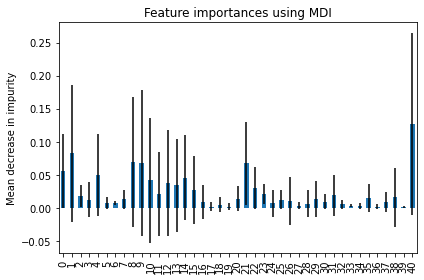

In [43]:
import matplotlib.pyplot as plt
importances = forest.feature_importances_
forest_importances = pd.Series(importances)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Nested Cross Validation

### Define Scorer as Required: LogLoss

In [44]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

def logloss(y_test, X_test_predicted):
  a = 0
  y_test_ls = y_test.tolist()
  for idx in range(X_test_predicted.shape[0]):
    # print(X_test_predicted[idx])
    target = y_test_ls[idx]
    a += -np.log(X_test_predicted[idx][target])

  return a / X_test_predicted.shape[0]

loss = make_scorer(logloss, greater_is_better=False, needs_proba = True)

### Nested K-Fold
##### Outer CV: 10 folds
##### Inner CV: 5 folds

In [ ]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=1)
outer_scores = []
cv_X = np.array(X)
cv_y = np.array(y)
for i, (train_idx, test_idx) in enumerate(cv.split(cv_X, cv_y)): 
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = cv_X[train_idx], cv_X[test_idx]
    y_train, y_test = cv_y[train_idx], cv_y[test_idx]  
    best_k, best_score = -1, -1
    param_grid = {'clf__n_estimators': [50, 100, 150, 200, 250],         # 可以再更大
             'clf__max_depth': [10, 20, 30, 40, 50],
             'clf__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
             'clf__colsample_bytree': [0.1, 0.3, 0.5, 0.7, 0.9]}

    # hyperparameter tuning 
    pipe = Pipeline([['sc', StandardScaler()],
              ['clf', XGBClassifier()]])
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid,
              scoring=loss, verbose=0, cv=inner_cv)
    gs.fit(X_train, y_train)

    # evaluate performance on test fold
    best_clf = gs.best_estimator_
    best_clf.fit(X_train, y_train)    
    y_pred = best_clf.predict_proba(X_test)
    outer_scores.append(logloss(y_test, y_pred))
    print(f'Test Loss: {outer_scores[i]} (parameters: {gs.best_estimator_})')

print(f'\nTest Loss: {np.mean(outer_scores)}')

In [45]:
best_clf.fit(X_train_scaled, y_train)
logloss(y_test, best_clf.predict_proba(X_test_scaled))

0.06286739714464748

### HyperParameters Fit on Whole Data

In [46]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
best_clf.fit(X_scaled, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


XGBClassifier(colsample_bytree=0.3, max_depth=4, n_estimators=275,
              objective='multi:softprob')

# Predict on Test Data

In [47]:
data_new = test_data.sort_values(["mac_hash", "Date", "Times"], ignore_index=True)

sub_label = pd.read_csv('submit_samples.csv')

### Same Prepocessing

In [48]:
table = pd.DataFrame(0, index=np.arange(len(sub_label['mac_hash'])), columns=np.arange(21))
table[0] = sub_label['mac_hash']
past_hash = None
past_Date = None
Dates = ['2018-12-06', '2018-12-07', '2018-12-08']
avg = 441.77
for idx, row in data_new.iterrows():
  if idx + 1 == len(data_new):
    index = table.index[table[0]==row["mac_hash"]].tolist()[0]
    table.iloc[index,row["sniffer_loc"]] += avg
    table.iloc[index, 20] += 1
    if row["Date"] == Dates[0]:
      table.iloc[index, 15] = 1.0
    elif row["Date"] == Dates[1]:
      table.iloc[index, 16] = 1.0
    elif row["Date"] == Dates[2]:
      table.iloc[index, 17] = 1.0
    break
  if idx + 1 != len(data_new):
    delta_time = data_new.iloc[idx + 1, 3] - row["Times"]
  index = table.index[table[0]==row["mac_hash"]].tolist()[0]
  table.iloc[index, 20] += 1
  # Date
  if row["Date"] == Dates[0]:
    table.iloc[index, 15] = 1.0
  elif row["Date"] == Dates[1]:
    table.iloc[index, 16] = 1.0
  elif row["Date"] == Dates[2]:
    table.iloc[index, 17] = 1.0

  # delta time
  if data_new.iloc[idx + 1, 0] != row["mac_hash"] or data_new.iloc[idx + 1, 2] != row["Date"]:
    index = table.index[table[0]==row["mac_hash"]].tolist()[0]
    table.iloc[index, row["sniffer_loc"]] += avg
  elif delta_time >= 1800:
    index = table.index[table[0]==row["mac_hash"]].tolist()[0]
    table.iloc[index, row["sniffer_loc"]] += avg
    table.iloc[index, 19] += 1.0
  elif delta_time <= 30:
    index = table.index[table[0]==row["mac_hash"]].tolist()[0]
    table.iloc[index, row["sniffer_loc"]] += 30
    table.iloc[index, 18] += 1.0
  else :
    index = table.index[table[0]==row["mac_hash"]].tolist()[0]
    table.iloc[index, row["sniffer_loc"]] += delta_time

In [49]:
columns = ['mac_hash', '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11st', '12nd', '13th', '14th', 'total']
table2 = pd.DataFrame(0, index=np.arange(len(sub_label['mac_hash'])), columns=columns)
table2['mac_hash'] = sub_label['mac_hash']
past_hash = None
past_Date = None
Dates = ['2018-12-06', '2018-12-07', '2018-12-08']
queue = 1
start_time = 0
start_date = None
for idx, row in data_new.iterrows():
  index = table2.index[table[0]==row["mac_hash"]].tolist()[0]

  if idx + 1 != len(data_new):
    # Ruined
    delta_time = data_new.iloc[idx + 1, 3] - row["Times"]
  elif data_new.iloc[idx - 1, 0] != row["mac_hash"]:
    queue = 1
    table2.iloc[index, queue] = row["sniffer_loc"]
    break
  else:
    queue += 1
    table2.iloc[index, queue] = row["sniffer_loc"]
    table2.loc[index, 'total'] = row["Times"] - start_time
    break

  # Queue
  if idx == 0:
    start_time = row["Times"]
    start_date = row['Date']
    queue = 1
  elif data_new.iloc[idx - 1, 0] != row["mac_hash"]:
    start_time = row["Times"]
    start_date = row['Date']
    queue = 1
  elif data_new.iloc[idx + 1, 0] != row["mac_hash"]:
    if start_date == row['Date']:
      table2.loc[index, 'total'] = row["Times"] - start_time
    queue += 1
  else:
    queue += 1
  table2.iloc[index, queue] = row["sniffer_loc"]

In [50]:
columns = ['mac_hash']
for i in range(6):
  columns.append(f'Stand_label_{i}')

test_stand_label = pd.DataFrame(0, index=np.arange(len(sub_label['mac_hash'])), columns=columns)
test_stand_label['mac_hash'] = sub_label['mac_hash']
past_hash = None
past_Date = None
for idx, row in data_new.iterrows():
  index = test_stand_label.index[test_stand_label['mac_hash']==row["mac_hash"]].tolist()[0]
  label = which_label(row['sniffer_loc'])
  test_stand_label.loc[index, f'Stand_label_{label}'] += 1.0

In [51]:
table.rename(columns={0: 'mac_hash'}, inplace=True)
concat = test_stand_label.merge(table2)
concat = concat.merge(table)

### Prediction to csv

In [52]:
X_sub = concat.drop(['mac_hash'], axis=1)
X_sub_scaled = scaler.transform(X_sub)
predicted = best_clf.predict_proba(X_sub_scaled)
column_names = ["mac_hash", "C0", "C1", "C2", "C3", "C4"]
lab = sub_label['mac_hash'].to_numpy().reshape(-1,1)
content = np.hstack((lab, predicted))
submit = pd.DataFrame(content, columns=column_names)
# submit.to_csv('submit.csv', index = False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
